In [1]:
# import the libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets.samples_generator import make_blobs

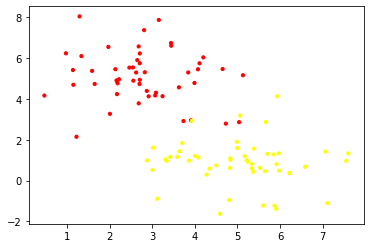

In [13]:
# obtain the data
X, y = make_blobs(n_samples = 100, centers = 2, cluster_std = 1.2)
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap='autumn')
plt.show()

### Using sklearn

In [14]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1)
model.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [15]:
def plot_boundary(X, y, model):
    '''
        Plot the decision boundary.
    '''
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.7, linestyles=['--', '-', '--'])
    
    # plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, linewidth=1)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

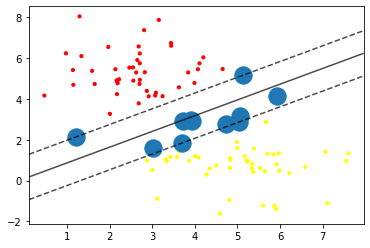

In [16]:
# C = 1
plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap='autumn')
plot_boundary(X, y, model)

In [17]:
model = SVC(kernel='linear', C=10)
model.fit(X, y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

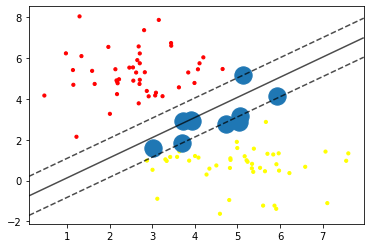

In [18]:
# C = 10
plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap='autumn')
plot_boundary(X, y, model)

# SVM in Python

### Solving the Quadratic Optimization problem using the SMO Algorithm

Paper: 
Platt, John. "Sequential minimal optimization: A fast algorithm for training support vector machines." (1998).

This is the simplified version of SMO Algorithm given here:
http://cs229.stanford.edu/materials/smo.pdf

Please refer to this amazing python implementation of simplified SMO:
https://www.youtube.com/watch?v=ZwGaLJbKHiQ

In [19]:
class SupportVectorMachine:
    def __init__(self, x, y, tol=0.001, C=1.0, passes=100):
        '''
            Initiate the SMO algorithm
        '''
        self.x_ = x
        self.y_ = y
        self.tol = tol
        self.C = C
        self.alphas = np.mat(np.zeros((self.x_.shape[0], 1)))
        self.b = np.mat([[0]])
        self.train(passes)
        self.calculate_weight()
        self.plot_support_vectors()
    
    def train(self, max_passes):
        '''
            SMO training
        '''
        passes = 0
        while passes < max_passes:
            if (self.compute_modified_alphas()==0): passes += 1
            else: passes = 0
        
    def compute_modified_alphas(self):
        '''
            Compute the modified alphas
        '''
        num_alpha_pairs_modified = 0
        
        for i in range(self.x_.shape[0]):
            Ei = self.calculate_error(i)
            if (self.check_kkt_conditions(Ei, i)):
                # randomly select an alpha to be optimized along with alpha[i], j is not equal to i 
                j = self.randomly_select_second_alpha(i)
                Ej = self.calculate_error(j)
                oldalphai, oldalphaj = self.alphas[i].copy(), self.alphas[j].copy()
                
                # compute bounds for alpha[j]
                low, high = self.compute_bounds(i, j)
                eta = 2.0 * self.x_[i] * self.x_[j].T - self.x_[i] * self.x_[i].T - self.x_[j] * self.x_[j].T

                if (low!=high and eta<0):
                    # compute new alpha[j]
                    self.compute_alphaj(j, Ei, Ej, eta, low, high)
                    if (np.abs(self.alphas[j]-oldalphaj) < pow(10, -5)):
                        continue

                    # use alpha[j] to update alpha[i]
                    self.alphas[i] += (self.y_[i] * self.y_[j] * (oldalphaj - self.alphas[j]))
                    
                    # update betas
                    self.update_betas(i, j, Ei, Ej, oldalphai, oldalphaj)

                    num_alpha_pairs_modified += 1
                    
        return num_alpha_pairs_modified
                        
    def update_betas(self, i, j, Ei, Ej, oldalphai, oldalphaj):
        '''
            Using equations 17, 18 and 19.
        '''
        b1 = self.b - Ei - self.y_[i] * (self.alphas[i]-oldalphai) * self.x_[i] * self.x_[i].T - self.y_[j] * (self.alphas[j]-oldalphaj) * self.x_[i] * self.x_[j].T
        b2 = self.b - Ej - self.y_[i] * (self.alphas[i]-oldalphai) * self.x_[i] * self.x_[j].T - self.y_[j] * (self.alphas[j]-oldalphaj) * self.x_[j] * self.x_[j].T

        if (0<self.alphas[i]<self.C):
            self.b = b1 
        elif (0<self.alphas[j]<self.C):
            self.b = b2
        else:
            self.b = (b1 + b2)/2.0
        
            
    def compute_alphaj(self, j, Ei, Ej, eta, L, H):
        '''
            Using equations 12 and 15.
        '''
        self.alphas[j] -= self.y_[j] * (Ei-Ej)/eta
        if self.alphas[j] < L:
            self.alphas[j] = L
        elif self.alphas[j] > H:
            self.alphas[j] = H
    
    def compute_bounds(self, i, j):
        '''
            Using equations 10 and 11.
        '''
        if self.y_[i] == self.y_[j]:
            L = max(0, self.alphas[i]+self.alphas[j]-self.C)
            H = min(self.C, self.alphas[i]+self.alphas[j])
        else:
            L = max(0, self.alphas[j]-self.alphas[i])
            H = min(self.C, self.C+self.alphas[j]-self.alphas[i])
        return L, H
                
    def randomly_select_second_alpha(self, i):
        secondind = i
        while i==secondind:
            secondind=np.random.randint(self.x_.shape[0])
        return secondind
        
    def check_kkt_conditions(self, Ei, i):
        return (self.y_[i]*Ei < -1*self.tol and self.alphas[i] < self.C) or (self.y_[i]*Ei > self.tol and self.alphas[i] > 0)
        
    def calculate_error(self, i):
        E = np.multiply(self.y_, self.alphas).T * self.x_ * self.x_[i].T + self.b - self.y_[i]
        return E
    
    def calculate_weight(self):
        self.w = np.zeros((self.x_.shape[1], 1))
        for i in range(self.y_.shape[0]):
            self.w += np.multiply(self.y_[i] * self.alphas[i], self.x_[i].T)
    
    def classification(self, x, classify=False):
        self.calculate_weight()
        output = np.dot(x,self.w)+self.b
        if classify: return np.sign(output)
        return output
    
    def plot_support_vectors(self):
        x = np.array(self.x_)
        y = np.array(self.y_).reshape(self.y_.shape[0])
        plt.scatter(x[:,0].reshape(x.shape[0]), x[:,1].reshape(x.shape[0]), c=y, s=10, cmap='winter')
        suppvec = np.nonzero(((self.alphas>0) & (self.alphas!=self.C)).astype(int))

        # plot the margins
        xlim = plt.xlim()
        ylim = plt.ylim()
        X = np.linspace(xlim[0], xlim[1], 30)
        Y = np.linspace(ylim[0], ylim[1], 30)
        X, Y = np.meshgrid(X, Y)
        xy = np.vstack((X.ravel(), Y.ravel())).T
        P = self.classification(xy).reshape(X.shape)
        plt.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.7, linestyles=['--', '-', '--'])
        
        # plot the support vectors
        plt.scatter(x[suppvec[0],0], x[suppvec[0],1], s=300, facecolor='none', edgecolor='black', label='support vectors')
        plt.legend()

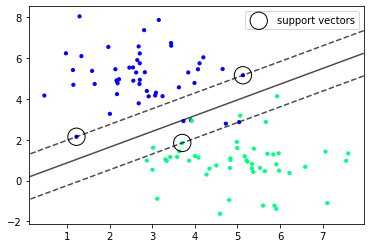

In [20]:
# C = 1
y1 = y.copy()
y1[y1==0] = -1
s = SupportVectorMachine(np.mat(X), np.mat(y1).T, C=1)

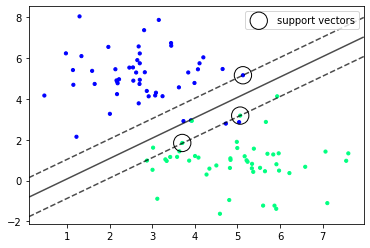

In [21]:
# C = 10
y1 = y.copy()
y1[y1==0] = -1
s = SupportVectorMachine(np.mat(X), np.mat(y1).T, C=10)

### Observe the effect of varying other variables

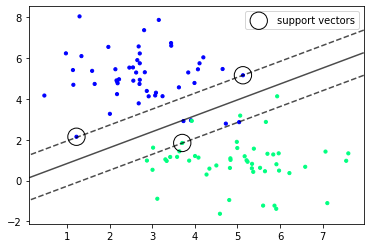

In [22]:
# C = 1, tol=0.1
y1 = y.copy()
y1[y1==0] = -1
s = SupportVectorMachine(np.mat(X), np.mat(y1).T, C=1, tol=0.1)

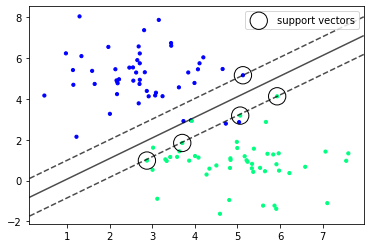

In [23]:
# C = 10, tol=0.1
y1 = y.copy()
y1[y1==0] = -1
s = SupportVectorMachine(np.mat(X), np.mat(y1).T, C=10, tol=0.1)

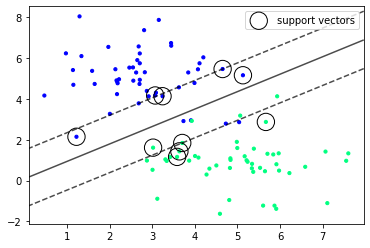

In [24]:
# C = 1, tol=0.6
y1 = y.copy()
y1[y1==0] = -1
s = SupportVectorMachine(np.mat(X), np.mat(y1).T, C=1, tol=0.6)

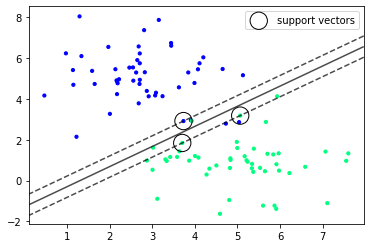

In [25]:
# C = 100, tol=0.001
y1 = y.copy()
y1[y1==0] = -1
s = SupportVectorMachine(np.mat(X), np.mat(y1).T, C=100, tol=0.001)

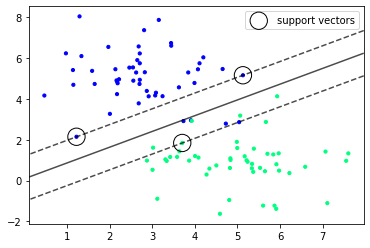

In [26]:
# C = 1, tol=0.999
y1 = y.copy()
y1[y1==0] = -1
s = SupportVectorMachine(np.mat(X), np.mat(y1).T, C=1, tol=0.001)

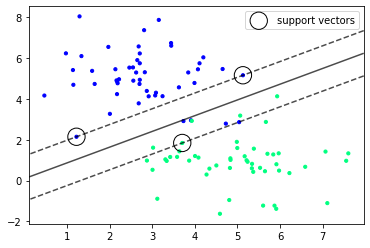

In [27]:
# C = 1, tol=0
y1 = y.copy()
y1[y1==0] = -1
s = SupportVectorMachine(np.mat(X), np.mat(y1).T, C=1, tol=0)

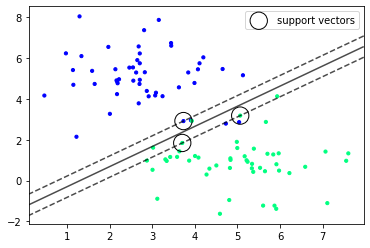

In [28]:
# C = 100, tol=0
y1 = y.copy()
y1[y1==0] = -1
s = SupportVectorMachine(np.mat(X), np.mat(y1).T, C=100, tol=0)